In [2]:
import pandas as pd
import sys
import os
from pathlib import Path
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae
sys.path.append(str(Path("..").resolve()))
from src.data.feature_engineering import date_features, lags, partial
from src.data.data_preprocessing import prepare_df
from utilsforecast.feature_engineering import pipeline, fourier
from functools import partial
from src.data.feature_engineering import  exg_features
from fine_tuning.models import xgboost_space
from fine_tuning.features import feature_space, fit_config
from mlforecast.auto import AutoMLForecast
from mlforecast.auto import AutoModel


## 1️⃣ Data preparation

In [3]:
# -------------------------------
# 1.1 Data Prepartion for Nixtla
# -------------------------------


raw_path =r'C:\Users\Guest\Desktop\ds-projects\Energy-Forecasting\data\raw\PJME_hourly.csv'


df= pd.read_csv(raw_path)  # raw CSV  
df = prepare_df(df)                      # clean, rename, add unique_id
df.head()

,ds,y,unique_id
8734,2002-01-01 01:00:00,30393.0,A
8735,2002-01-01 02:00:00,29265.0,A
8736,2002-01-01 03:00:00,28357.0,A
8737,2002-01-01 04:00:00,27899.0,A
8738,2002-01-01 05:00:00,28057.0,A


In [4]:
# -------------------------------
# 1.2 Split into train and test
# -------------------------------
split_date = '2018-08-02'

train = df[df['ds'] < split_date ]
test  = df[df['ds'] >= split_date ]

print(f'Train shape: {train.shape}, Test shape: {test.shape}')

Train shape: (145341, 3), Test shape: (25, 3)


## Feature Engineering 

In [5]:
# -------------------------------
# 2. Apply exogenous features
# -------------------------------
# exg_features() returns list of feature functions (Fourier, etc.)




exg_df, future_df = pipeline(train , freq='h', h=len(test), features=exg_features())
print(f'Exogenous df shape: {exg_df.shape}')


Exogenous df shape: (145341, 7)


In [6]:
exg_df.tail()

,ds,y,unique_id,sin1_24,sin2_24,cos1_24,cos2_24
140273,2018-08-01 19:00:00,48428.0,A,-0.966698,0.494794,-0.255920,-0.869010
140274,2018-08-01 20:00:00,46912.0,A,-0.999996,-0.005840,0.002920,-0.999983
140275,2018-08-01 21:00:00,45985.0,A,-0.965187,-0.504909,0.261560,-0.863172
140276,2018-08-01 22:00:00,44094.0,A,-0.864643,-0.868771,0.502387,-0.495215
140277,2018-08-01 23:00:00,40666.0,A,-0.705211,-0.999986,0.708998,0.005356


In [9]:
future_df.head()

,unique_id,ds,sin1_24,sin2_24,cos1_24,cos2_24
0,A,2018-08-02 00:00:00,-0.497749,-0.863416,0.867321,0.504492
1,A,2018-08-02 01:00:00,-0.256387,-0.495635,0.966574,0.868531
2,A,2018-08-02 02:00:00,0.002436,0.004872,0.999997,0.999988
3,A,2018-08-02 03:00:00,0.261093,0.504074,0.965314,0.863660
4,A,2018-08-02 04:00:00,0.501969,0.868291,0.864886,0.496055


In [80]:
test

,ds,y,unique_id
140245,2018-08-02 15:00:00,47154.0,A
140246,2018-08-02 16:00:00,46989.0,A
140247,2018-08-02 17:00:00,46816.0,A
140248,2018-08-02 18:00:00,46760.0,A
140249,2018-08-02 19:00:00,45641.0,A
140250,2018-08-02 20:00:00,44057.0,A
140251,2018-08-02 21:00:00,43256.0,A
140252,2018-08-02 22:00:00,41552.0,A
140253,2018-08-02 23:00:00,38500.0,A
140254,2018-08-03 00:00:00,35486.0,A


In [10]:
len(test)

25

## 2️⃣ Models Training

In [13]:
# ===============================
# 
# ===============================


# Configure AutoMLForecast with both model and feature tuning


auto_mlf = AutoMLForecast(
                models={'custom_xgb': AutoModel(model=xgb.XGBRegressor(), config=xgboost_space)}, 
                freq='h',                                             
                init_config=feature_space,    
                fit_config=fit_config
                
                
                
            )

In [14]:
auto_mlf.fit(df=exg_df , 
                     n_windows= 2,
                     h= len(test), 
                     num_samples= 10,
                     
 )
#print(f'cross validation results', cv_df.head())
#print(f'✅ Models trained successfully!')


[I 2026-01-11 12:45:02,011] A new study created in memory with name: no-name-35ec6343-bb0d-4420-a464-3e7fb8831b21
[I 2026-01-11 12:45:18,923] Trial 0 finished with value: 0.04294776612007464 and parameters: {'learning_rate': 0.0646642271741456, 'n_estimators': 829, 'extra_lag': 1000}. Best is trial 0 with value: 0.04294776612007464.
[I 2026-01-11 12:45:32,980] Trial 1 finished with value: 0.03833717966521238 and parameters: {'learning_rate': 0.04429649570464297, 'n_estimators': 935, 'extra_lag': 0}. Best is trial 1 with value: 0.03833717966521238.
[I 2026-01-11 12:45:46,954] Trial 2 finished with value: 0.03729172045720644 and parameters: {'learning_rate': 0.06903521707993515, 'n_estimators': 956, 'extra_lag': 1000}. Best is trial 2 with value: 0.03729172045720644.
[I 2026-01-11 12:45:58,882] Trial 3 finished with value: 0.056036022515079796 and parameters: {'learning_rate': 0.1410690937355148, 'n_estimators': 922, 'extra_lag': 0}. Best is trial 2 with value: 0.03729172045720644.
[I 20

AutoMLForecast(models={'custom_xgb': AutoModel(model=XGBRegressor)})

In [15]:
df_pred = auto_mlf.predict(h=len(future_df), 
                           X_df=future_df,
                           )
df_pred.head()


,unique_id,ds,custom_xgb
0,A,2018-08-02 00:00:00,36934.941406
1,A,2018-08-02 01:00:00,33922.101562
2,A,2018-08-02 02:00:00,31975.357422
3,A,2018-08-02 03:00:00,30672.099609
4,A,2018-08-02 04:00:00,29833.761719


In [16]:
auto_mlf.results_['custom_xgb'].best_params

{'learning_rate': 0.029236536416560464, 'n_estimators': 618, 'extra_lag': 500}

## 4️⃣ Evaluation and plotting

In [17]:
from utilsforecast.evaluation import evaluate


merg_df = pd.merge(df_pred,test, on =['unique_id', 'ds'],how='left')
eval_df = evaluate(merg_df,metrics= [mae])
eval_df.head()

,unique_id,metric,custom_xgb
0,A,mae,1357.602578


In [ ]:
merg_df

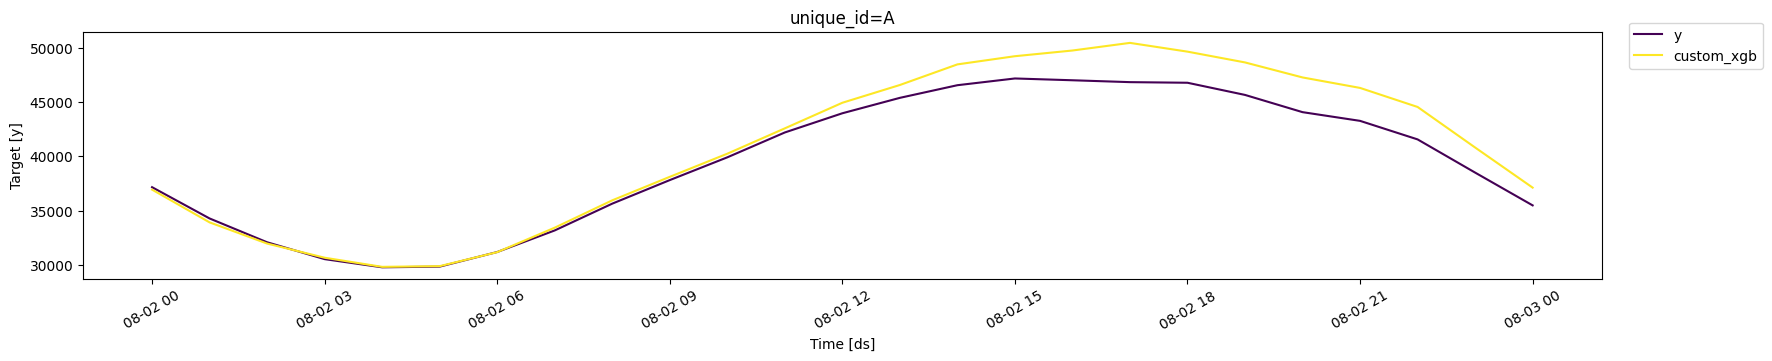

In [19]:
# 3.2 plotting



# 3.2 plotting

from utilsforecast.plotting import plot_series


plot_series(df=test, 
                forecasts_df=df_pred[-200:], 
                max_insample_length=200, 
                palette='viridis', 
              )

In [ ]:
import os
os.getcwd()

'c:\\Users\\Guest\\Desktop\\ds-projects\\Energy-Forecasting\\notbooks'